# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1]:
# Load the libraries as required.

# loadinng environment variable
%load_ext dotenv
%dotenv 

In [25]:
# importing libraries
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, PowerTransformer, PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestClassifier
from sklearn.svm import SVR
import numpy as np
import pickle
import os
import shap
import warnings
warnings.filterwarnings('ignore')


In [26]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.shape


(517, 13)

# Get X and Y

Create the features data frame and target data.

In [27]:
X = fires_dt.iloc[:, :-1]
X

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0


In [28]:
Y = fires_dt.iloc[:, -1]
Y
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [29]:
num_col = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
cat_col = [ 'month', 'day']


transformer = ColumnTransformer(
    transformers=[
        ('num_transform', MaxAbsScaler(), num_col ),
        ('cat_transform', OneHotEncoder(handle_unknown='infrequent_if_exist', drop='if_binary'), cat_col), 
    ], remainder='drop'
)

transformer


,transformers,"[('num_transform', ...), ('cat_transform', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,categories,'auto'
,drop,'if_binary'


### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [30]:
non_linear_transformer = ColumnTransformer(
    transformers=[
        ('num_transform', MaxAbsScaler(), num_col ),
        ('cat_transform', OneHotEncoder(handle_unknown='infrequent_if_exist', drop='if_binary'), cat_col), 
        ('non_linear_transform', PolynomialFeatures(), num_col),
    ], remainder='drop'
)

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [31]:
scoring=['neg_mean_absolute_error', 'neg_mean_squared_error']

In [32]:
# Pipeline A = preproc1 + baseline
pipe_a = Pipeline(
    [
        ('preprocessing', transformer), 
        ('knn', KNeighborsRegressor()),
    ]
)


parameter_grid = {
    "knn__n_neighbors": range(1, 270), # n_neighbors ranging from 1 to 50
}

grid_cv = GridSearchCV(
    estimator=pipe_a, 
    param_grid=parameter_grid, 
    scoring = scoring, 
    cv = 5,
    refit = "neg_mean_squared_error")

grid_cv.fit(X_train, Y_train)

best_k = grid_cv.best_params_['knn__n_neighbors']

print(f"The optimal k value is: {best_k}")

#scoring=['neg_root_mean_squared_error', 'neg_mean_squared_error', 'r2']

pipe_a_2 = Pipeline(
    [
        ('preprocessing', transformer), 
        ('knn', KNeighborsRegressor(n_neighbors=best_k)),
    ]
)


dict_1 = cross_validate(pipe_a_2, X, Y, cv=5, scoring = scoring, return_train_score = True)
dict_df = pd.DataFrame(dict_1)

dict_df



The optimal k value is: 254


,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error
0,0.003016,0.010112,-16.824105,-23.041479,-288.449360,-4985.256248
1,0.003903,0.011050,-12.530803,-23.056801,-176.304703,-5000.435534
2,0.002659,0.010315,-32.907890,-10.744027,-13341.731952,-1753.587782
3,0.004018,0.009981,-14.387047,-21.063814,-466.857093,-4905.762398
4,0.003921,0.009021,-23.877613,-16.916299,-6466.836781,-3417.129414


In [33]:
# Pipeline B = preproc2 + baseline
pipe_b = Pipeline(
    [
        ('preprocessing', non_linear_transformer), 
        ('regressor', Lasso()),
    ]
)

dict_b = cross_validate(pipe_b, X, Y, cv=5, scoring = scoring, return_train_score = True)
dict_b_df = pd.DataFrame(dict_b)

dict_b_df


,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error
0,0.017998,0.004002,-25.303042,-24.318714,-1174.510623,-4500.579084
1,0.014996,0.003004,-17.041492,-24.086630,-445.975967,-4571.842620
2,0.014996,0.004006,-38.425452,-13.264538,-13563.635592,-1561.953101
3,0.014502,0.003004,-23.712371,-23.008360,-1171.406277,-4451.289185
4,0.014971,0.003003,-29.738223,-17.523318,-6510.175712,-3179.773032


In [34]:
# Pipeline C = preproc1 + advanced model
pipe_c = Pipeline(
    [
        ('preprocessing', transformer), 
        ('regressor', SVR()),
    ]
)

dict_c = cross_validate(pipe_c, X, Y, cv=5, scoring = scoring, return_train_score = True)
dict_c_df = pd.DataFrame(dict_c)

dict_c_df

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error
0,0.010110,0.005481,-2.335123,-15.429453,-6.100008,-5192.743779
1,0.009013,0.004983,-3.358183,-15.013801,-27.949431,-5235.790123
2,0.009096,0.003999,-32.861690,-7.726545,-13758.223486,-1811.920110
3,0.008744,0.004064,-8.903320,-13.610083,-500.675041,-5110.148185
4,0.008909,0.005105,-19.132893,-11.073915,-6762.971813,-3541.979128


In [35]:
# Pipeline D = preproc2 + advanced model
pipe_d = Pipeline(
    [
        ('preprocessing', non_linear_transformer), 
        ('regressor',  BaggingRegressor())
    ]
)

dict_d = cross_validate(pipe_d, X, Y, cv=5, scoring = scoring, return_train_score = True)
dict_d_df = pd.DataFrame(dict_d)

dict_d_df
    

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error
0,0.155240,0.004107,-20.984038,-9.210655,-1175.833878,-630.844329
1,0.149549,0.006456,-9.942724,-11.325256,-292.091252,-1457.778640
2,0.157843,0.004005,-34.377717,-5.849898,-13556.881028,-526.704285
3,0.149741,0.004996,-28.450901,-11.641384,-4514.047289,-1470.129727
4,0.145039,0.004224,-33.201358,-7.524785,-7131.113059,-1187.491572


# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [36]:
parameter_grid = {
    "knn__n_neighbors": range(1, 270), # n_neighbors ranging from 1 to 50
}

grid_cv = GridSearchCV(
    estimator=pipe_a, 
    param_grid=parameter_grid, 
    scoring = scoring, 
    cv = 5,
    refit = "neg_mean_squared_error")

grid_cv.fit(X_train, Y_train)

best_k = grid_cv.best_params_['knn__n_neighbors']

print(f"The optimal k value is: {best_k}")

#scoring=['neg_root_mean_squared_error', 'neg_mean_squared_error', 'r2']

pipe_a_2 = Pipeline(
    [
        ('preprocessing', transformer), 
        ('knn', KNeighborsRegressor(n_neighbors=best_k)),
    ]
)


dicta = cross_validate(pipe_a_2, X, Y, cv=5, scoring = scoring, return_train_score = True)
dicta_df = pd.DataFrame(dict_1)
dicta_df

The optimal k value is: 254


,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error
0,0.003016,0.010112,-16.824105,-23.041479,-288.449360,-4985.256248
1,0.003903,0.011050,-12.530803,-23.056801,-176.304703,-5000.435534
2,0.002659,0.010315,-32.907890,-10.744027,-13341.731952,-1753.587782
3,0.004018,0.009981,-14.387047,-21.063814,-466.857093,-4905.762398
4,0.003921,0.009021,-23.877613,-16.916299,-6466.836781,-3417.129414


In [37]:
alphas = np.logspace(-4, 2, 100) 
parameter_grid = {'regressor__alpha': range(-4, 20)}


grid_cv = GridSearchCV(
    estimator=pipe_b, 
    param_grid=parameter_grid, 
    scoring = "neg_mean_squared_error", 
    cv = 5)

grid_cv.fit(X_train, Y_train)

best_alpha = grid_cv.best_params_['regressor__alpha']
best_score = grid_cv.best_score_
print(f"Best Alpha is {best_alpha}")
print(f"Best Score is {best_score}")

pipe_b_2 = Pipeline(
    [
        ('preprocessing', non_linear_transformer), 
        ('regressor', Lasso(alpha = best_alpha)),
    ]
)

dict_b = cross_validate(pipe_b_2, X, Y, cv=5, scoring = scoring, return_train_score = True)
dict_b_df = pd.DataFrame(dict_b)

dict_b_df


Best Alpha is 19
Best Score is -2381.928045101147


,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error
0,0.014889,0.004000,-20.467949,-23.363535,-787.654248,-4717.350124
1,0.014020,0.003102,-13.159344,-23.358710,-272.894550,-4755.315325
2,0.013521,0.003896,-37.766323,-12.483602,-13542.770653,-1591.210546
3,0.014253,0.004002,-21.766048,-22.255161,-1060.229578,-4611.212411
4,0.017005,0.002997,-27.820340,-16.277373,-6522.643779,-3323.768554


In [38]:
parameter_grid = {
    'regressor__C': [0.1, 1, 10, 100],
    'regressor__gamma': [0.0005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5 ],
    'regressor__kernel': ['rbf', 'linear', 'poly']
}

grid_cv_svr = GridSearchCV(
    estimator=pipe_c,
    param_grid=parameter_grid, 
    scoring = "neg_mean_squared_error", 
    cv = 5)

grid_cv_svr.fit(X_train, Y_train)

print("Best parameters found: ", grid_cv_svr.best_params_)
best_regressor__C = grid_cv_svr.best_params_['regressor__C']
best_regressor__gamma = grid_cv_svr.best_params_['regressor__gamma']
best_regressor__kernel = grid_cv_svr.best_params_['regressor__kernel']

pipe_c_2 = Pipeline(
    [
        ('preprocessing', transformer), 
        ('regressor', SVR(C=best_regressor__C,gamma=best_regressor__gamma, kernel=best_regressor__kernel )),
    ]
)

dict_c_2 = cross_validate(pipe_c_2, X, Y, cv=5, scoring = scoring, return_train_score = True)
dict_c_2_df = pd.DataFrame(dict_c_2)

dict_c_2_df

Best parameters found:  {'regressor__C': 100, 'regressor__gamma': 0.0005, 'regressor__kernel': 'linear'}


,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error
0,0.025512,0.004001,-2.888127,-15.411694,-10.734940,-5174.778826
1,0.034002,0.003999,-3.339626,-14.973935,-28.209851,-5226.309043
2,0.051462,0.004002,-33.084550,-7.680289,-13756.757969,-1804.118743
3,0.075249,0.005024,-8.943562,-13.584545,-502.753525,-5107.510799
4,0.138526,0.003004,-19.303815,-11.023822,-6740.505304,-3533.873757


In [39]:
parameter_grid = {
    'regressor__n_estimators': range(5,25),
    'regressor__max_features': range(1,13)
}

grid_cv = GridSearchCV(
    estimator=pipe_d,
    param_grid=parameter_grid, 
    scoring = "neg_mean_squared_error", 
    cv = 5)

grid_cv.fit(X_train, Y_train)

print("Best parameters found: ", grid_cv.best_params_)
best_regressor__n_estimators = grid_cv.best_params_['regressor__n_estimators']
best_regressor__max_features= grid_cv.best_params_['regressor__max_features']

pipe_d_2 = Pipeline(
    [
        ('preprocessing', transformer), 
        ('regressor', BaggingRegressor( n_estimators = best_regressor__n_estimators, max_features = best_regressor__max_features )),
    ]
)

dict_d_2 = cross_validate(pipe_d_2, X, Y, cv=5, scoring = scoring, return_train_score = True)
dict_d_2_df = pd.DataFrame(dict_d_2)

dict_d_2_df

Best parameters found:  {'regressor__max_features': 1, 'regressor__n_estimators': 24}


,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error
0,0.025526,0.003986,-17.330466,-20.760349,-333.432784,-4280.583545
1,0.025020,0.003979,-11.005805,-21.130858,-148.898747,-4522.538394
2,0.023988,0.004005,-32.485135,-10.626396,-13362.785329,-1608.409079
3,0.024515,0.003999,-13.224126,-19.124620,-478.693234,-4213.903603
4,0.022989,0.004012,-23.237653,-15.888462,-6445.582821,-3112.726926


# Evaluate

+ Which model has the best performance?

# Export

+ Save the best performing model to a pickle file.

In [40]:
grid_cv_svr.best_estimator_

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_transform', ...), ('cat_transform', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [41]:
os.makedirs("./models", exist_ok=True)

In [42]:
with open('./models/forestfires_grid_search.pkl', 'wb') as f:
    pickle.dump(grid_cv_svr.best_estimator_, f)

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [43]:
with open('./models/forestfires_grid_search.pkl', 'rb') as f:
    pipe = pickle.load(f)

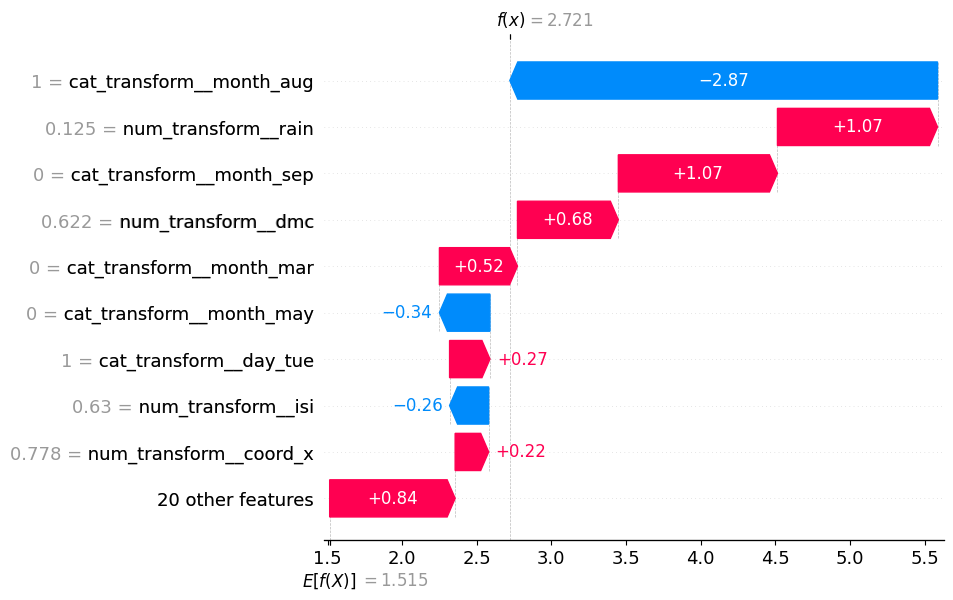

In [44]:
pipe
data_transform = pipe.named_steps['preprocessing'].transform(X_test)

explainer = shap.explainers.Linear(
    pipe.named_steps['regressor'], 
    data_transform,
    feature_names = pipe.named_steps['preprocessing'].get_feature_names_out())

shap_values = explainer(data_transform)

shap.plots.waterfall(shap_values[1])

*(Answer here.)*

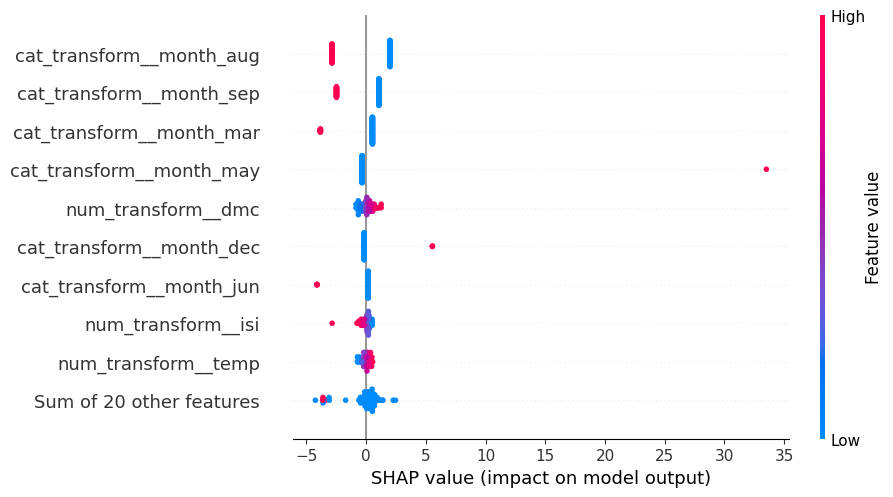

In [45]:
shap.plots.beeswarm(shap_values)

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.